In [32]:
%config IPCompleter.greedy=True

In [33]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Input, concatenate
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import model_from_json

import matplotlib.pyplot as plt
import numpy as np

In [34]:
batch_size = 32
n_classes = 10
epochs = 40

In [35]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [36]:
height = x_train.shape[1]
width = x_train.shape[2]

In [37]:
x_val = x_train[:5000]
y_val = y_train[:5000]
x_train = x_train[5000:]
y_train = y_train[5000:]

In [38]:
print('Training dataset: ', x_train.shape, y_train.shape)
print('Validation dataset: ', x_val.shape, y_val.shape)
print('Test dataset: ', x_test.shape, y_test.shape)

Training dataset:  (45000, 32, 32, 3) (45000, 1)
Validation dataset:  (5000, 32, 32, 3) (5000, 1)
Test dataset:  (10000, 32, 32, 3) (10000, 1)


In [39]:
def plot(data, answer, text, begin=0, end = 5):
    cols = 3
    fig = plt.figure()
    label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    print(text)
    count = 0
    for i in range(begin, end):
        a = fig.add_subplot(cols, np.ceil(n_classes/float(cols)), count + 1)
        #img_num = np.random.randint(data.shape[0])
        image = data[i]
        id = answer[i]
        pos = np.argmax(id)
        plt.imshow(image)
        a.set_title(label_names[pos])
        count += 1
    fig.set_size_inches(8,8)
    plt.show()

training:


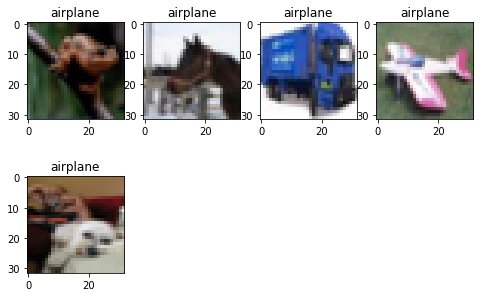

validation:


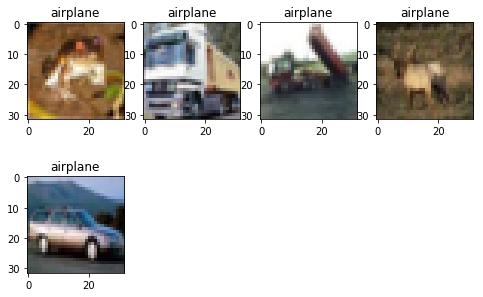

test:


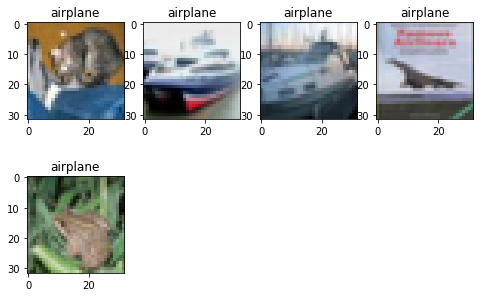

In [40]:
plot(x_train, y_train, 'training:')
plot(x_val, y_val, 'validation:')
plot(x_test, y_test, 'test:')

In [41]:
# Convert labels to categorical
y_train = to_categorical(y_train, n_classes)
y_val = to_categorical(y_val, n_classes)
y_test = to_categorical(y_test, n_classes)

In [42]:
# Datasets pre-processing
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_val /= 255
x_test /= 255

In [43]:
def optimizer():
    return SGD(lr=1e-2)

In [87]:
def create_model2():
    input_shape = Input(shape=(height, width, 3))
    merged = input_shape
    for i in range(0, 2):
        tower_1 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', strides=1)(merged)
        tower_1 = MaxPooling2D(pool_size=(1+i,1+i))(tower_1)

        
        tower_2 = Conv2D(filters=128, kernel_size=(1,1), padding='same', activation='relu', strides=1)(merged)
        tower_2 = MaxPooling2D(pool_size=(1+i,1+i))(tower_2)
        
        tower_3 = Conv2D(filters=128, kernel_size=(7,7), padding='same', activation='relu', strides=1)(merged)
        tower_3 = MaxPooling2D(pool_size=(1+i,1+i))(tower_3)
        
        merged = concatenate([tower_1, tower_2, tower_3], axis=1)
        
        merged = Dropout(0.25)(merged)
    
    merged = Flatten()(merged)    
    out = Dense(64, activation='relu')(merged)
    out = Dense(n_classes, activation='softmax')(out)
    
    model = Model(input_shape, out)
    
    return model
    

In [80]:
def create_model():
    model = Sequential()
    model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(height, width, 3), strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(2, 2), strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(1,1)))
    model.add(Conv2D(filters=32, kernel_size=(2, 2), strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(1,1)))
    model.add(Conv2D(filters=32, kernel_size=(2, 2), strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(1,1)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [90]:
model_name = 'model7'
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction=0.8
with tf.Session(config=config) as sess:
    try:
        model = load_model(model_name)
    except:
        model = create_model2()
    model.compile(optimizer=optimizer(),
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )
    model.fit(x_train, y_train, batch_size=batch_size, epochs=1, validation_data=(x_val,y_val),verbose=1)
    model.summary()
    save_model(model, model_name)

Loaded model from disk
Train on 45000 samples, validate on 5000 samples
45000/45000 [==============================] - 268s 6ms/sample - loss: 0.7417 - acc: 0.7419 - val_loss: 1.0638 - val_acc: 0.6310
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 32, 32, 128)  3584        input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 32, 32, 128)  512         input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_

In [49]:
def save_model(model, name='model5'):
    # serialize model to JSON
    model_json = model.to_json()
    with open("{0}.json".format(name), "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("{0}.h5".format(name))
    print("Saved model to disk")

In [50]:
# load json and create model
def load_model(name='model5'):
    json_file = open("{0}.json".format(name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("{0}.h5".format(name))
    print("Loaded model from disk")
    return loaded_model


In [19]:
model = load_model()
model.compile(optimizer=optimizer(),
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

Loaded model from disk


In [54]:
save_model(model)

Saved model to disk


In [34]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100), "| Loss: %.5f" % (scores[0]))

Accuracy: 62.50% | Loss: 1.76864


In [22]:
result = model.predict(x_val)

Resultado


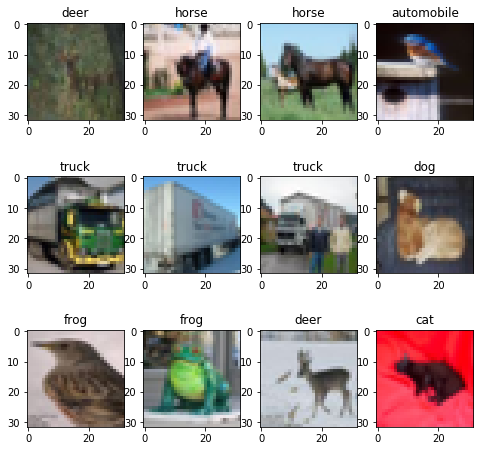

In [40]:
plot(x_val, result, "Resultado", 10,22)

In [24]:
result

array([[9.30868191e-06, 3.92514230e-05, 7.62291951e-03, ...,
        8.69945565e-04, 5.77550600e-06, 6.91683672e-05],
       [3.81624210e-04, 1.17069604e-02, 1.65040501e-06, ...,
        1.33961094e-05, 4.61795898e-05, 9.87844110e-01],
       [1.26701202e-02, 4.07584235e-02, 4.72362910e-04, ...,
        2.46465392e-02, 2.27586555e-04, 9.17974174e-01],
       ...,
       [4.55838046e-04, 2.82932393e-04, 2.90472955e-02, ...,
        1.04941083e-02, 9.81658159e-05, 2.10982194e-04],
       [5.46591082e-06, 3.97047515e-08, 1.38025098e-02, ...,
        3.59100811e-02, 5.04784694e-08, 1.40320117e-06],
       [7.17915100e-05, 8.50388096e-06, 3.43948215e-01, ...,
        2.17390334e-04, 1.18553864e-04, 8.91576917e-07]], dtype=float32)

In [4]:
tf.config.list_physical_devices('GPU')

AttributeError: module 'tensorflow._api.v1.config' has no attribute 'list_physical_devices'

In [19]:
sess.list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 6045682950220617763),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 8239711648483665802),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8727261954375217269),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 1230569472, 485717206293540505)]